In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import schema_to_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetPath('enron-mail-20150507')
schema = DatasetSchema.load_schema(DATASET.name)
G = schema_to_igraph(schema)

Dropping extra args {'id': 'id'}
Dropping extra args {'id': 'id'}


In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: True
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

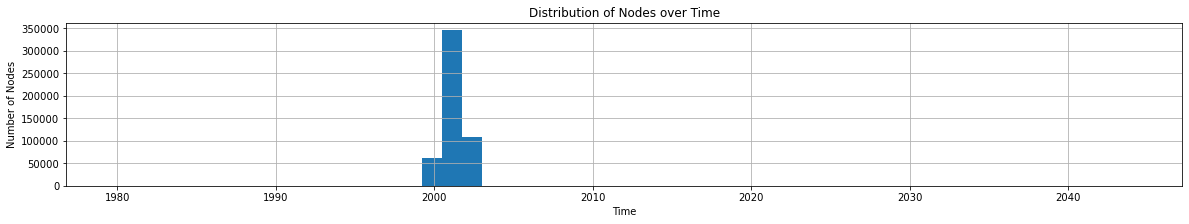

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 605076
Number of Edges: 4179878
Density: 2.2833604005066797e-05


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 13.816042943365792
Median Degree: 2.0


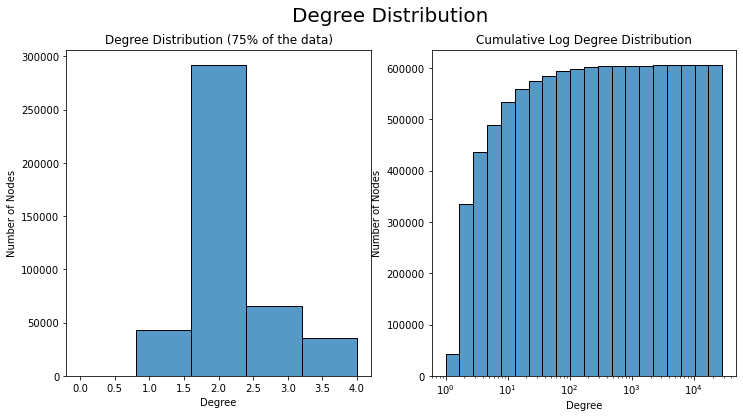

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,28568,jeff.dasovich@enron.com
1,27523,pete.davis@enron.com
2,26378,vince.kaminski@enron.com
3,24886,kay.mann@enron.com
4,23741,tana.jones@enron.com
5,22907,sara.shackleton@enron.com
6,22876,steven.kean@enron.com
7,20226,richard.shapiro@enron.com
8,17140,mark.taylor@enron.com
9,14374,james.steffes@enron.com


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.0
Diameter: 24


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

Eigenvector Centrality Error: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')


,degree_centrality,betweenness_centrality,page_rank,transitivity
count,592983.000000,5.929830e+05,5.929830e+05,548584.0
mean,0.000024,5.599831e-06,1.686389e-06,0.0
std,0.000256,9.315461e-04,2.619228e-05,0.0
min,0.000002,0.000000e+00,2.688745e-07,0.0
25%,0.000003,0.000000e+00,4.575430e-07,0.0
50%,0.000003,5.121281e-11,5.740513e-07,0.0
75%,0.000008,9.340627e-08,7.732148e-07,0.0
max,0.048177,5.550704e-01,6.544692e-03,0.0


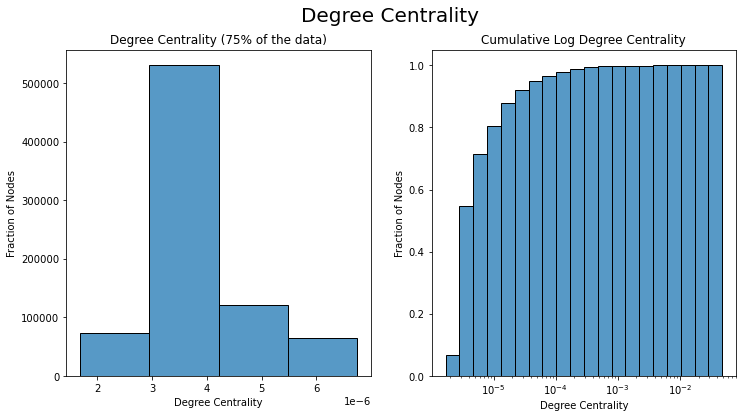

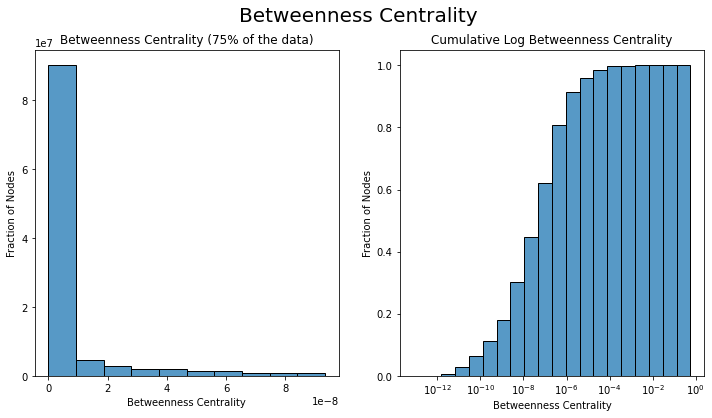

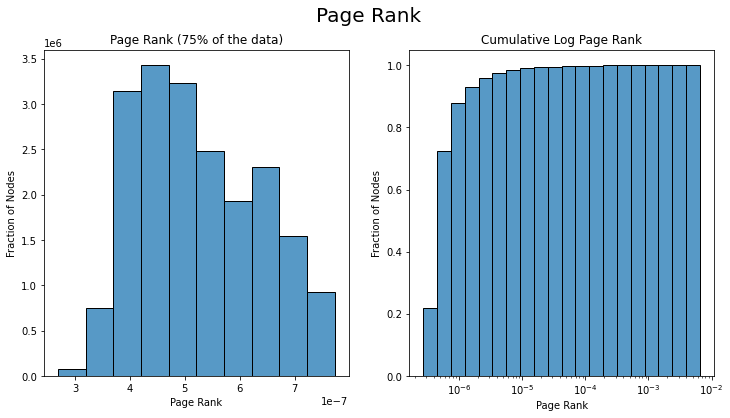

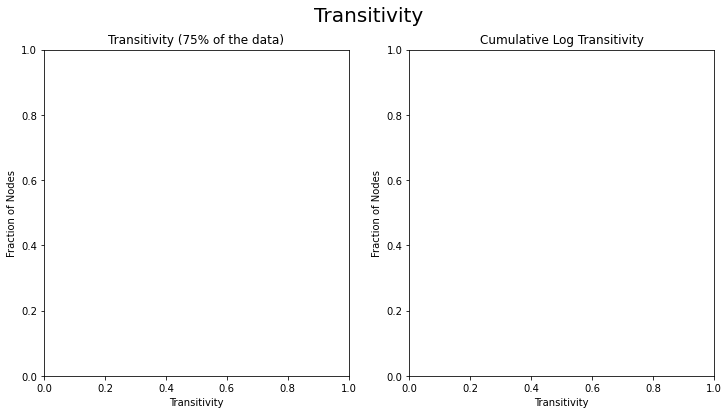

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.048177,jeff.dasovich@enron.com,0.555070,steven.kean@enron.com,0.006545,kay.mann@enron.com,0.0,louise.kitchen@enron.com
1,0.046415,pete.davis@enron.com,0.444930,mark.frevert@enron.com,0.006475,vince.kaminski@enron.com,0.0,FW: no bull?
2,0.044484,vince.kaminski@enron.com,0.033753,jeff.dasovich@enron.com,0.004847,sara.shackleton@enron.com,0.0,"Coffee & Donuts, Friday 8:00 - 9:00 a.m."
3,0.041968,kay.mann@enron.com,0.032859,vince.kaminski@enron.com,0.004759,no.address@enron.com,0.0,Evil Twin
4,0.040037,tana.jones@enron.com,0.026195,kay.mann@enron.com,0.004539,tana.jones@enron.com,0.0,Re: Organizational Announcement: Industrial Or...
5,0.038630,sara.shackleton@enron.com,0.019161,sara.shackleton@enron.com,0.004275,jeff.dasovich@enron.com,0.0,Energy Stocks are at the Bottom of a Cyclical ...
6,0.038578,steven.kean@enron.com,0.017871,mark.taylor@enron.com,0.004264,enron.announcements@enron.com,0.0,Approve IT Hardware Purchase Requests with iBu...
7,0.034109,richard.shapiro@enron.com,0.017391,sally.beck@enron.com,0.003639,steven.kean@enron.com,0.0,Employee Meeting Postponed
8,0.028905,mark.taylor@enron.com,0.016800,enron.announcements@enron.com,0.003219,mark.taylor@enron.com,0.0,Re:
9,0.024240,james.steffes@enron.com,0.015924,tana.jones@enron.com,0.002892,chris.germany@enron.com,0.0,Re: Invoice for approval


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 1618
Size of the largest component: 592983


Text(0.5, 1.0, 'Connected Components')

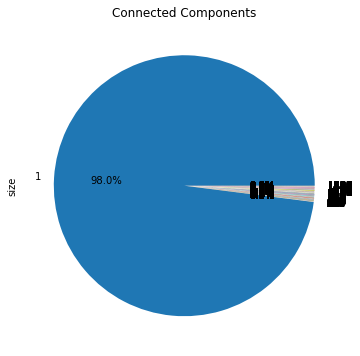

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components())], index=range(1,len(G.components())+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 2


,type,count,degree_avg,degree_median
User,User,87678,47.673054,3.0
Email,Email,517398,8.078651,2.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

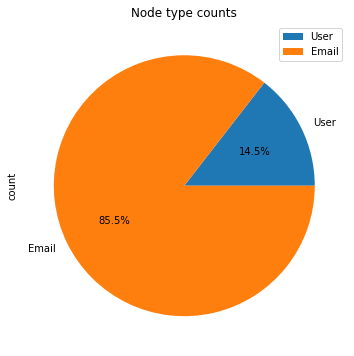

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

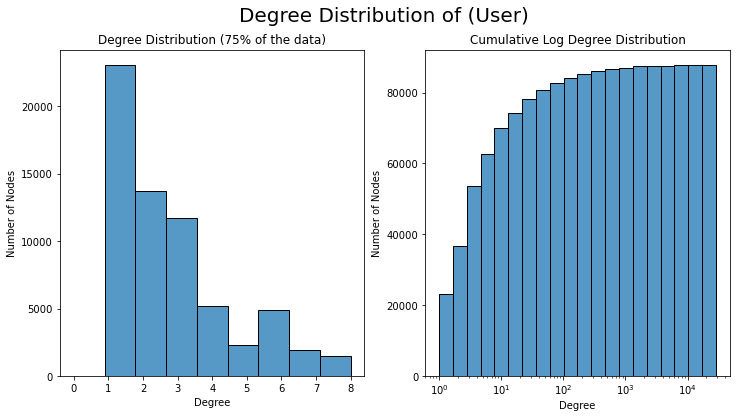

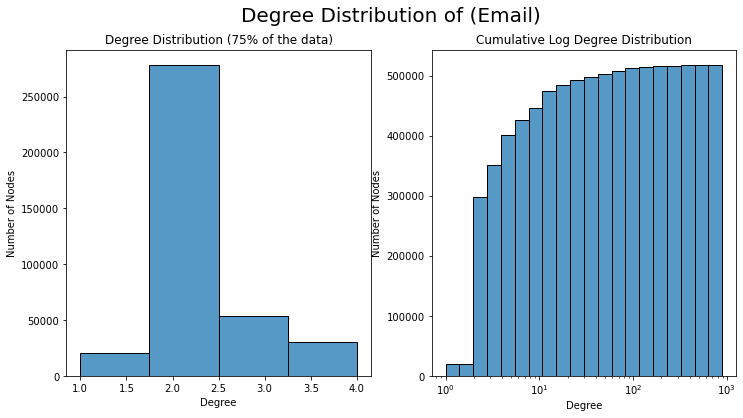

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (User)


,value,label
0,28568,jeff.dasovich@enron.com
1,27523,pete.davis@enron.com
2,26378,vince.kaminski@enron.com
3,24886,kay.mann@enron.com
4,23741,tana.jones@enron.com
5,22907,sara.shackleton@enron.com
6,22876,steven.kean@enron.com
7,20226,richard.shapiro@enron.com
8,17140,mark.taylor@enron.com
9,14374,james.steffes@enron.com


Top 10 Degree Nodes of Type (Email)


,value,label
0,892,Updated Cougars@Enron Email List
1,883,Associate/Analyst Program
2,883,Associate/Analyst Program
3,883,Associate/Analyst Program
4,883,Associate/Analyst Program
5,883,Associate/Analyst Program
6,883,Associate/Analyst Program
7,882,Associate/Analyst Program
8,882,Associate/Analyst Program
9,820,"Solar Migration - October 13-14, 2001 - Second..."


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 3


,type,count
SENT,SENT,517398
RECEIVED,RECEIVED,3101175
RECEIVED_CC,RECEIVED_CC,561305


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

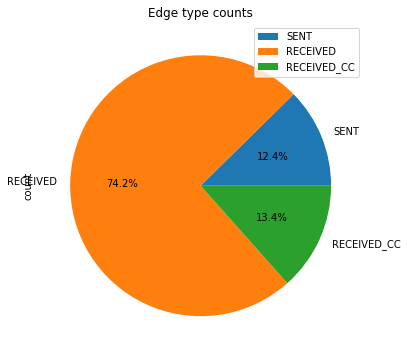

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.048177,jeff.dasovich@enron.com,0.555070,steven.kean@enron.com,0.006545,kay.mann@enron.com,0.0,sheila.knudsen@enron.com
1,0.046415,pete.davis@enron.com,0.444930,mark.frevert@enron.com,0.006475,vince.kaminski@enron.com,0.0,mary.johnson@enron.com
2,0.044484,vince.kaminski@enron.com,0.033753,jeff.dasovich@enron.com,0.004847,sara.shackleton@enron.com,0.0,cassia_look@pgn.com
3,0.041968,kay.mann@enron.com,0.032859,vince.kaminski@enron.com,0.004759,no.address@enron.com,0.0,brian.silver@enron.com
4,0.040037,tana.jones@enron.com,0.026195,kay.mann@enron.com,0.004539,tana.jones@enron.com,0.0,teresabrown@duke-energy.com
5,0.038630,sara.shackleton@enron.com,0.019161,sara.shackleton@enron.com,0.004275,jeff.dasovich@enron.com,0.0,dennis.keener@williams.com
6,0.038578,steven.kean@enron.com,0.017871,mark.taylor@enron.com,0.004264,enron.announcements@enron.com,0.0,mike.brosnan@occ.treas.gov
7,0.034109,richard.shapiro@enron.com,0.017391,sally.beck@enron.com,0.003639,steven.kean@enron.com,0.0,mikl@texas.net
8,0.028905,mark.taylor@enron.com,0.016800,enron.announcements@enron.com,0.003219,mark.taylor@enron.com,0.0,kkeis@mindspring.com
9,0.024240,james.steffes@enron.com,0.015924,tana.jones@enron.com,0.002892,chris.germany@enron.com,0.0,darryn.light@bnpparibas.com


Top 10 Nodes by Statistic for Email


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001504,Updated Cougars@Enron Email List,0.008190,EnronOnline URGENT - Please read,0.000421,Reminder and update for tomorrow's Roundtable,0.0,
1,0.001489,Associate/Analyst Program,0.008190,EnronOnline URGENT - Please read,0.000302,GasEDI Standard Contract,0.0,XMS Upgrade Transition Plan - All XMS Users Pl...
2,0.001489,Associate/Analyst Program,0.007141,Analyst & Associate Program - e-Speak Invitati...,0.000264,Doyle goes to Global Energy Markets (G.E.M.)!!,0.0,Enron - PGT Payout Table
3,0.001489,Associate/Analyst Program,0.007113,Analyst & Associate Program - e-Speak Invitati...,0.000249,RE: Closing of ENNEC Department,0.0,TRAINING OPPORTUNITY: Derivatives II (11.14.01...
4,0.001489,Associate/Analyst Program,0.007113,Analyst & Associate Program - e-Speak Invitati...,0.000242,"Fw: WENH Membership ""Reminder Notice""",0.0,Re: TW Letter
5,0.001489,Associate/Analyst Program,0.004208,Associate/Analyst Program,0.000241,Fall 2001 Football Update,0.0,TransCanada Energy Marketing USA / TransCanada...
6,0.001489,Associate/Analyst Program,0.004208,Associate/Analyst Program,0.000233,Email Address Change,0.0,FW: Smarts
7,0.001487,Associate/Analyst Program,0.004208,Associate/Analyst Program,0.000217,National Day of Prayer,0.0,Re: FW: Letter agreement
8,0.001487,Associate/Analyst Program,0.004208,Associate/Analyst Program,0.000202,Legal Update,0.0,Re: Genesys
9,0.001383,"Solar Migration - October 13-14, 2001 - Second...",0.004208,Associate/Analyst Program,0.000195,Maxwell Museum Update,0.0,"Turkey, Poland and Italy"


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.7268259871311143
Number of communities: 237


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

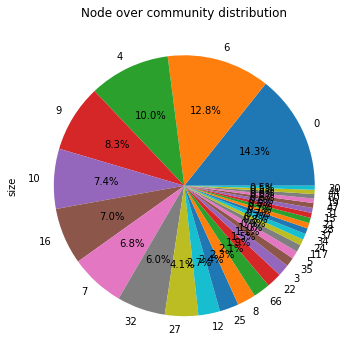

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.023852,chris.germany@enron.com,0.014514,chris.germany@enron.com,0.002892,chris.germany@enron.com,0.0,#2.martin@enron.com
1,0.015323,matthew.lenhart@enron.com,0.009448,matthew.lenhart@enron.com,0.002253,matthew.lenhart@enron.com,0.0,
2,0.013921,eric.bass@enron.com,0.008190,EnronOnline URGENT - Please read,0.001935,eric.bass@enron.com,0.0,Re: 318923
3,0.012076,john.arnold@enron.com,0.008190,EnronOnline URGENT - Please read,0.001556,john.arnold@enron.com,0.0,
4,0.010606,scott.neal@enron.com,0.007968,mike.grigsby@enron.com,0.001068,phillip.love@enron.com,0.0,FW: Inactive account - Greg Schockling
5,0.010419,mike.grigsby@enron.com,0.007859,john.arnold@enron.com,0.001008,mike.grigsby@enron.com,0.0,Global Facilites - Maintenace Request - Comple...
6,0.009397,phillip.allen@enron.com,0.007071,eric.bass@enron.com,0.000991,scott.neal@enron.com,0.0,Re: New Years
7,0.007764,phillip.love@enron.com,0.005296,phillip.allen@enron.com,0.000948,phillip.allen@enron.com,0.0,RE:
8,0.007467,errol.mclaughlin@enron.com,0.004962,scott.neal@enron.com,0.000802,errol.mclaughlin@enron.com,0.0,FW: TE Restriction for Oct 18-19
9,0.006344,barry.tycholiz@enron.com,0.004818,errol.mclaughlin@enron.com,0.000738,mike.maggi@enron.com,0.0,FW: Gas Daily Deals


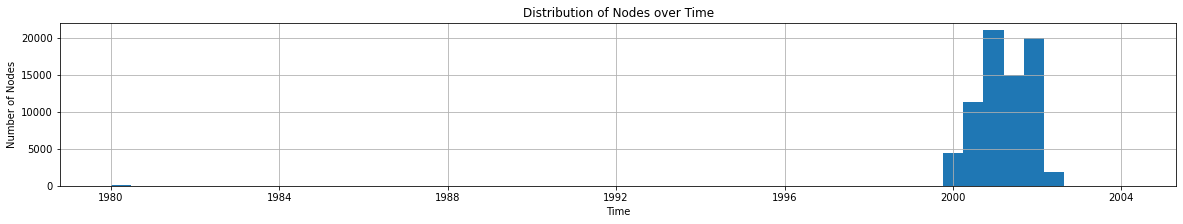

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.001042,mark.e.haedicke@enron.com,0.001607,mark.e.haedicke@enron.com,0.000139,Quantitative Finance Update from FinMath.com @...,0.0,'blanchard@enron.com
1,0.000757,Quantitative Finance Update from FinMath.com @...,0.000232,Quantitative Finance Update from FinMath.com @...,0.000139,Quantitative Finance Update from FinMath.com @...,0.0,Reverse Engineering...
2,0.000757,Quantitative Finance Update from FinMath.com @...,0.000232,Quantitative Finance Update from FinMath.com @...,0.000139,Quantitative Finance Update from FinMath.com @...,0.0,e-mail address
3,0.000757,Quantitative Finance Update from FinMath.com @...,0.000232,Quantitative Finance Update from FinMath.com @...,0.000123,mark.e.haedicke@enron.com,0.0,"ISDA PRESS REPORT FOR NOVEMBER 15, 2000"
4,0.000432,rpickel@isda.org,0.000203,scarey@isda.org,0.000066,FW: CDD,0.0,4 February 2002 - A place and time for all pow...
5,0.000410,scarey@isda.org,0.000173,mhaedic@ect.enron.com,0.000066,FW: CDD,0.0,Board Book materials
6,0.000366,FW: CDD,0.000136,FW: CDD,0.000046,mhaedic@ect.enron.com,0.0,Government talks up renewable initiative
7,0.000366,FW: CDD,0.000136,FW: CDD,0.000043,SDR Task Force Meeting - Email One,0.0,ISDA Tax Committee - comment letter on propose...
8,0.000314,rainslie@isda.org,0.000130,joseph.bauman@bankamerica.com,0.000042,scarey@isda.org,0.0,"Asia Power 2002 - Your chance to meet CLP, EGA..."
9,0.000290,mcunningham@isda.org,0.000114,SDR Task Force Meeting - Email One,0.000035,Re: 2001 ISDA Master Agreement Protocol,0.0,European Energy Committee Meeting


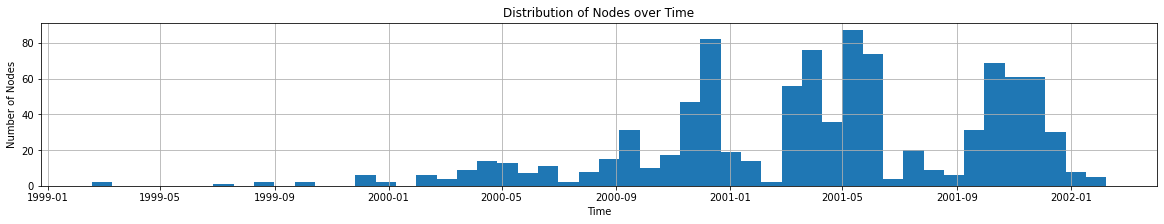

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000175,FYI,0.000224,andrew.h.lewis@enron.com,0.000069,New Sae Page Alumni Section,0.0,'.''ann@enron.com
1,0.000175,FYI,0.000136,New Sae Page Alumni Section,0.000034,FYI,0.0,"Re: big lew, is it yew?"
2,0.000175,FYI,0.000102,FW: Nudge your co-workers!,0.000034,FYI,0.0,big lew in the house.
3,0.000123,New Sae Page Alumni Section,0.000102,FW: Nudge your co-workers!,0.000034,FYI,0.0,MONEY LAUNDERING SCAM - A-LETTER 12-11-00
4,0.000116,jennifer_lamprecht@oxy.com,0.000102,FW: Nudge your co-workers!,0.000025,Fw: Another Texas joke,0.0,Prebon Yamane's Energy Holiday Party
5,0.000116,tkuyken@enron.com,0.000102,FW: Nudge your co-workers!,0.000020,tkuyken@enron.com,0.0,FW: Everyone can relate to this!
6,0.000103,susan.hadix@elpaso.com,0.000080,tkuyken@enron.com,0.000017,jennifer_lamprecht@oxy.com,0.0,RE: Baby Shower for Tripp--action items
7,0.000076,FW: optical illusion,0.000058,Fw: Another Texas joke,0.000015,susan.hadix@elpaso.com,0.0,peru
8,0.000073,New Address and Phone Number,0.000055,FYI,0.000015,andrew.h.lewis@enron.com,0.0,FW: Nudge your co-workers!
9,0.000073,New Address and Phone Number,0.000055,FYI,0.000013,FW: optical illusion,0.0,RE: Monthly Girls Night Dinner


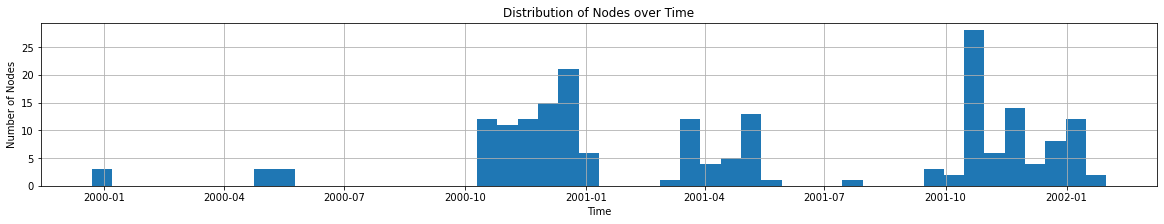

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.006692,jdasovic@enron.com,0.003408,jdasovic@enron.com,0.000532,jdasovic@enron.com,0.0,'.'delaney@enron.com
1,0.003123,smara@enron.com,0.000911,sscott3@enron.com,0.000135,smara@enron.com,0.0,SDG&E Advice Letters
2,0.002113,gtbl@dynegy.com,0.000233,richard.costigan@asm.ca.gov,0.000103,richard.costigan@asm.ca.gov,0.0,wrong number
3,0.001928,kmccrea@sablaw.com,0.000220,jfawcet@enron.com,0.000074,Assembly Tax Suspense File,0.0,RE: I.99-07-003
4,0.001599,sscott3@enron.com,0.000206,Assembly Tax Suspense File,0.000074,Assembly Tax Suspense File,0.0,Re: California Lawmakers Vote to Limit Power C...
5,0.001563,eke@aelaw.com,0.000206,Assembly Tax Suspense File,0.000067,sscott3@enron.com,0.0,
6,0.001482,cabaker@duke-energy.com,0.000199,kevin.lynch@pacificorp.com,0.000055,venturewire@venturewire.com,0.0,Re: REVISED Merged Leg Document
7,0.001460,craigc@calpine.com,0.000179,Memorandum from Julie Simon,0.000046,kmccrea@sablaw.com,0.0,"Re: Energy Briefing paper for Thursday, May 3rd"
8,0.001442,rick.counihan@greenmountain.com,0.000179,Memorandum from Julie Simon,0.000044,mbaldwin@igservice.com,0.0,January e.Bulletin
9,0.001430,jleslie@luce.com,0.000179,Memorandum from Julie Simon,0.000042,CAISO Notice - Discretionary Load Curtailment ...,0.0,SDG&E


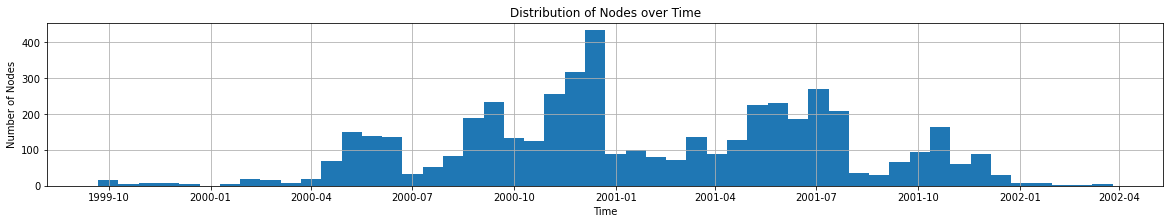

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.048177,jeff.dasovich@enron.com,0.555070,steven.kean@enron.com,0.004275,jeff.dasovich@enron.com,0.0,'.'@enron.com
1,0.038578,steven.kean@enron.com,0.033753,jeff.dasovich@enron.com,0.003639,steven.kean@enron.com,0.0,President Banzer/President Clinton Meeting in NYC
2,0.034109,richard.shapiro@enron.com,0.013020,richard.shapiro@enron.com,0.002392,richard.shapiro@enron.com,0.0,Re: Government Affairs Strategy for Dahbol - T...
3,0.024240,james.steffes@enron.com,0.007241,richard.sanders@enron.com,0.001519,james.steffes@enron.com,0.0,RE: NERC Statements on Impact of Security Thre...
4,0.020247,susan.mara@enron.com,0.006781,tim.belden@enron.com,0.001366,richard.sanders@enron.com,0.0,El Paso Announces Binding Open Season for Addi...
5,0.017704,paul.kaufman@enron.com,0.003942,mary.hain@enron.com,0.001175,susan.mara@enron.com,0.0,Re: Draft letter to the CPUC
6,0.016240,tim.belden@enron.com,0.003720,james.steffes@enron.com,0.001022,paul.kaufman@enron.com,0.0,"Morning Market View for October 25, 2001"
7,0.014790,richard.sanders@enron.com,0.003580,william.bradford@enron.com,0.000959,tim.belden@enron.com,0.0,Urgent - Steve Kean to testify at Senate heari...
8,0.013422,karen.denne@enron.com,0.002943,susan.mara@enron.com,0.000877,maureen.mcvicker@enron.com,0.0,RE: I'm Leaving Enron
9,0.012940,harry.kingerski@enron.com,0.002935,paul.kaufman@enron.com,0.000835,karen.denne@enron.com,0.0,Final report from the Cal PX on the summer prices


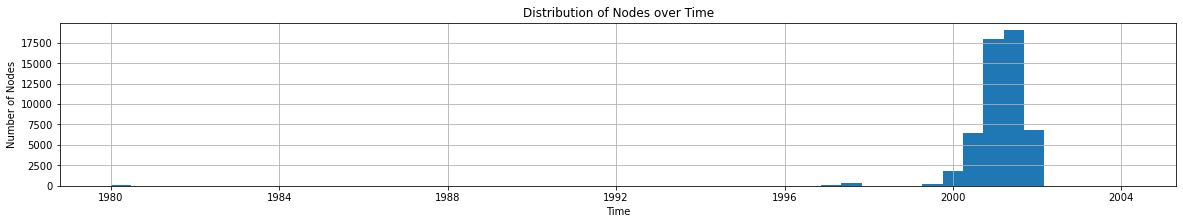

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000444,Email Address Change,0.000806,Kevin Garland Joins The Sterling Group,0.000242,"Fw: WENH Membership ""Reminder Notice""",0.0,'allison'@enron.com
1,0.000406,"Fw: WENH Membership ""Reminder Notice""",0.000423,Email Address Change,0.000233,Email Address Change,0.0,"Into Cinergy Hourly Index for November 27, 2001"
2,0.000341,5K Freedom Run on Veteran's Day,0.000403,"Fw: WENH Membership ""Reminder Notice""",0.000161,5K Freedom Run on Veteran's Day,0.0,RE: LOCATION FOR MAN NIGHT
3,0.000329,chet_fenner@bmc.com,0.000307,5K Freedom Run on Veteran's Day,0.000156,New Email Address,0.0,RE: MAN NIGHT FINAL PLANS
4,0.000325,e-mail <.john@enron.com>,0.000264,New Email Address,0.000109,"El Paso Natural Gas Company Dockets RP00-336, ...",0.0,hello
5,0.000322,erwollam@hotmail.com,0.000206,"El Paso Natural Gas Company Dockets RP00-336, ...",0.000088,erwollam@hotmail.com,0.0,"RE: Good News, Lease Signed"
6,0.000312,wollam.erik@enron.com,0.000139,e-mail <.john@enron.com>,0.000073,0155770.pdfopenelement.pdf,0.0,FW: Pledge of Allegiance
7,0.000282,Bonneville Power Administration News Release,0.000139,erwollam@hotmail.com,0.000056,chet_fenner@bmc.com,0.0,TNRCC on ERCs and DERCs
8,0.000280,News Release - Bush Administration proposes 19...,0.000137,0155770.pdfopenelement.pdf,0.000055,Bonneville Power Administration News Release,0.0,RE: surf looking realy good
9,0.000273,New Email Address,0.000110,Bonneville Power Administration News Release,0.000055,News Release - Bush Administration proposes 19...,0.0,


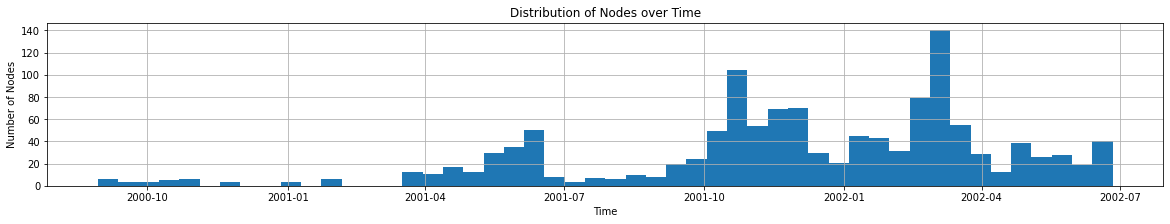

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.6376866650392529
Number of communities: 2304


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

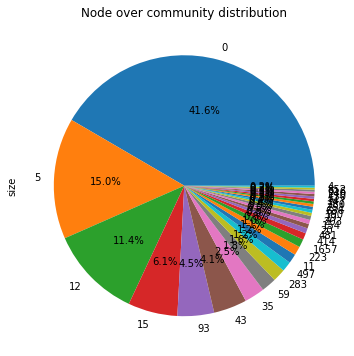

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.023852,chris.germany@enron.com,0.017391,sally.beck@enron.com,0.002892,chris.germany@enron.com,0.0,#2.martin@enron.com
1,0.022682,sally.beck@enron.com,0.014514,chris.germany@enron.com,0.002547,gerald.nemec@enron.com,0.0,Headcount
2,0.019751,gerald.nemec@enron.com,0.012813,gerald.nemec@enron.com,0.002402,sally.beck@enron.com,0.0,
3,0.019083,louise.kitchen@enron.com,0.011444,louise.kitchen@enron.com,0.001784,louise.kitchen@enron.com,0.0,Hermes Fee Letter
4,0.018783,john.lavorato@enron.com,0.010081,john.lavorato@enron.com,0.001763,john.lavorato@enron.com,0.0,RE: Settles
5,0.016319,elizabeth.sager@enron.com,0.010021,daren.farmer@enron.com,0.001740,daren.farmer@enron.com,0.0,Floor Talk follow up survey
6,0.016196,daren.farmer@enron.com,0.008444,elizabeth.sager@enron.com,0.001564,elizabeth.sager@enron.com,0.0,Re: Amendment to Fuel Supply
7,0.012076,john.arnold@enron.com,0.008190,EnronOnline URGENT - Please read,0.001556,john.arnold@enron.com,0.0,RE: Good job for Chrissy
8,0.011010,jeffrey.shankman@enron.com,0.008190,EnronOnline URGENT - Please read,0.001181,jeffrey.shankman@enron.com,0.0,RE:
9,0.010606,scott.neal@enron.com,0.007968,mike.grigsby@enron.com,0.001068,phillip.love@enron.com,0.0,Re: Calpine Power Services/Calpine Energy Serv...


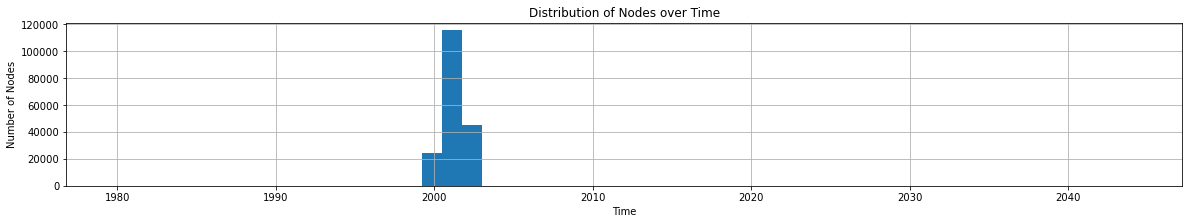

Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000083,Meetings on Netting Provisions,2.293987e-05,Friday Meetings on Netting Provisions - Details,0.000012,Friday Meetings on Netting Provisions - Details,0.0,'blanchard@enron.com
1,0.000083,Friday Meetings on Netting Provisions - Details,2.000087e-05,Meetings on Netting Provisions,0.000012,Meetings on Netting Provisions,0.0,kmckechn@aba.com
2,0.000078,Netting Legislation Conference Call - 2:30 p.m...,1.747127e-05,Netting Legislation Conference Call - 2:30 p.m...,0.000011,Netting Legislation Conference Call - 2:30 p.m...,0.0,levyr@citi.com
3,0.000066,Bankruptcy Letters & Conference Call Tomorrow ...,1.410083e-05,Bankruptcy Letters & Conference Call Tomorrow ...,0.000009,Bankruptcy Letters & Conference Call Tomorrow ...,0.0,loneill@bear.com
4,0.000019,BANKRUPTCY CONFERENCE CALL TODAY AT 2:00 p.m.,2.762166e-06,strupp_cory@jpmorgan.com,0.000002,BANKRUPTCY CONFERENCE CALL TODAY AT 2:00 p.m.,0.0,martin.mcguinness@wc.ey.com
5,0.000015,fhampton@bondmarkets.com,2.647892e-06,BANKRUPTCY CONFERENCE CALL TODAY AT 2:00 p.m.,0.000002,fhampton@bondmarkets.com,0.0,mdandridge@bondmarkets.com
6,0.000012,strupp_cory@jpmorgan.com,9.207218e-07,loneill@bear.com,0.000001,jvogt@bondmarkets.com,0.0,michael.nelson@ny.frb.org
7,0.000012,jvogt@bondmarkets.com,0.000000e+00,mwilliams@bondmarkets.com,0.000001,strupp_cory@jpmorgan.com,0.0,msolomon@fsround.org
8,0.000008,loneill@bear.com,0.000000e+00,kmckechn@aba.com,0.000001,lawrence.brandman@gs.com,0.0,mwilliams@bondmarkets.com
9,0.000008,blanchardl@citi.com,0.000000e+00,lawrence.brandman@gs.com,0.000001,jeanne-marie.murphy@bankofamerica.com,0.0,norm.nelson@nych.org


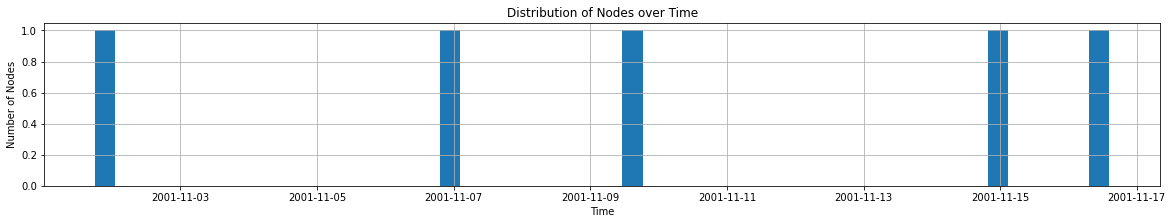

Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000044,RE: FERC To Examine Alleged Market Manipulatio...,0.000030,RE: FERC To Examine Alleged Market Manipulatio...,1.063788e-05,RE: FERC To Examine Alleged Market Manipulatio...,0.0,'.''ann@enron.com
1,0.000044,RE: FERC To Examine Alleged Market Manipulatio...,0.000030,RE: FERC To Examine Alleged Market Manipulatio...,1.063788e-05,RE: FERC To Examine Alleged Market Manipulatio...,0.0,'.''karen@enron.com
2,0.000007,'.'phil@enron.com,0.000022,'.'mike@enron.com,1.109647e-06,'.'mike@enron.com,0.0,RE: FERC To Examine Alleged Market Manipulatio...
3,0.000005,'.'mike@enron.com,0.000000,'.''karen@enron.com,8.994954e-07,'.'phil@enron.com,0.0,'.'tom@enron.com
4,0.000003,'.''karen@enron.com,0.000000,'.'tom@enron.com,7.139956e-07,'.''karen@enron.com,0.0,'.'phil@enron.com
5,0.000003,'.'tom@enron.com,0.000000,'.'phil@enron.com,7.139956e-07,'.'tom@enron.com,0.0,'.'mike@enron.com
6,0.000003,'.''robert@enron.com,0.000000,'.''robert@enron.com,7.139956e-07,'.''robert@enron.com,0.0,'.''robert@enron.com
7,0.000003,'.''mike@enron.com,0.000000,'.''mike@enron.com,7.139956e-07,'.''mike@enron.com,0.0,'.''mike@enron.com
8,0.000003,'.''marc@enron.com,0.000000,'.''marc@enron.com,7.139956e-07,'.''marc@enron.com,0.0,'.''marc@enron.com
9,0.000003,'.''linda@enron.com,0.000000,'.''linda@enron.com,7.139956e-07,'.''linda@enron.com,0.0,'.''linda@enron.com


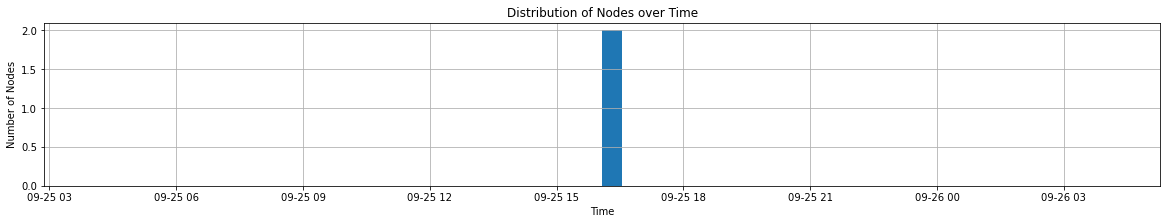

Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000005,RE:,0.000003,RE:,2.633254e-06,RE:,0.0,RE:
1,0.000002,'.''matthew@enron.com,0.000000,'.''matthew@enron.com,8.254517e-07,'.''matthew@enron.com,NaN,'.''matthew@enron.com
2,0.000002,'.'truong@enron.com,0.000000,'.'truong@enron.com,8.254517e-07,'.'truong@enron.com,NaN,'.'truong@enron.com


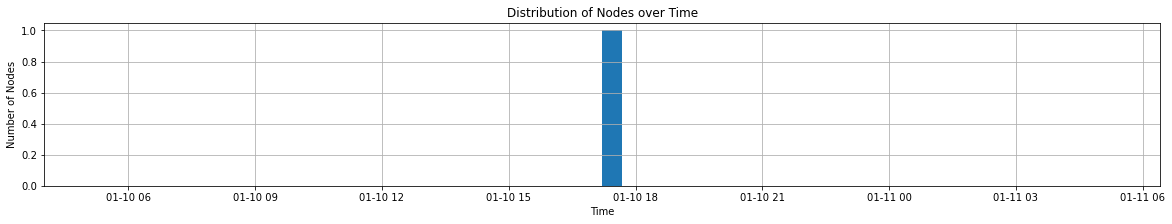

Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000698,vjw@cleanpower.org,0.000157,jjackson@haas.berkeley.edu,0.000067,mark_guinney@watsonwyatt.com,0.0,'.'delaney@enron.com
1,0.000653,dhunter@s-k-w.com,0.000081,guinney@haas.berkeley.edu,0.000063,dwindham@uclink4.berkeley.edu,0.0,Angelides Oct. 19th Letter to L. Lynch Urging ...
2,0.000637,jjackson@haas.berkeley.edu,0.000036,vjw@cleanpower.org,0.000052,jjackson@haas.berkeley.edu,0.0,PowerPoint info
3,0.000634,dwindham@uclink4.berkeley.edu,0.000026,asama@yahoo.com,0.000048,cvavrek@deloitte.com,0.0,Re: Next Financial Reporting Case
4,0.000626,brbarkovich@earthlink.net,0.000023,dominic.dimare@calchamber.com,0.000047,kkupiecki@arpartners.com,0.0,RE: Here it is...
5,0.000587,isenberg@hmot.com,0.000022,cvavrek@deloitte.com,0.000046,jcjcal02@aol.com,0.0,Re: Teams
6,0.000575,mark_guinney@watsonwyatt.com,0.000022,mark_guinney@watsonwyatt.com,0.000036,asama@yahoo.com,0.0,Re: Indexdata
7,0.000541,dominic.dimare@calchamber.com,0.000018,drothrock@cmta.net,0.000035,vjw@cleanpower.org,0.0,Next Meeting of Hertzberg Work Group
8,0.000526,fieldejr@sce.com,0.000009,drothrock@camfg.com,0.000034,dhunter@s-k-w.com,0.0,"Re: Conf Call on Mon., May 14"
9,0.000494,jcjcal02@aol.com,0.000009,dwindham@uclink4.berkeley.edu,0.000031,guinney@haas.berkeley.edu,0.0,Re[2]: Clarkson


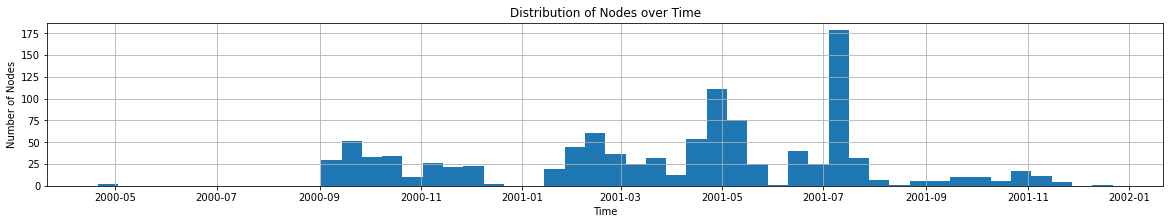

Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.048177,jeff.dasovich@enron.com,0.555070,steven.kean@enron.com,0.004275,jeff.dasovich@enron.com,0.0,'.'@enron.com
1,0.038578,steven.kean@enron.com,0.444930,mark.frevert@enron.com,0.003639,steven.kean@enron.com,0.0,Re: mccubbin and dasovich to Denver
2,0.034109,richard.shapiro@enron.com,0.033753,jeff.dasovich@enron.com,0.002392,richard.shapiro@enron.com,0.0,California order
3,0.024240,james.steffes@enron.com,0.013020,richard.shapiro@enron.com,0.001519,james.steffes@enron.com,0.0,EBS
4,0.020247,susan.mara@enron.com,0.008815,jeff.skilling@enron.com,0.001366,richard.sanders@enron.com,0.0,"Enron Corp.: Enron Unit,New England Market Dow..."
5,0.017704,paul.kaufman@enron.com,0.007241,richard.sanders@enron.com,0.001175,susan.mara@enron.com,0.0,RE: Direct Report Mtg in November (Activity)
6,0.016240,tim.belden@enron.com,0.006781,tim.belden@enron.com,0.001148,mike.mcconnell@enron.com,0.0,
7,0.014790,richard.sanders@enron.com,0.006133,kenneth.lay@enron.com,0.001038,david.delainey@enron.com,0.0,RE: Enron Management Committee Meeting on Wedn...
8,0.013422,karen.denne@enron.com,0.006097,mike.mcconnell@enron.com,0.001022,paul.kaufman@enron.com,0.0,"Savett Frutkin Podell & Ryan, P.C. Announces C..."
9,0.012940,harry.kingerski@enron.com,0.004562,greg.whalley@enron.com,0.001012,greg.whalley@enron.com,0.0,Enron Candidate


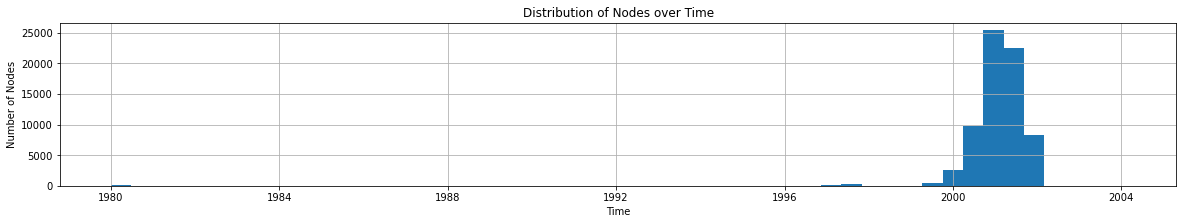

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')